In [14]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataroot = 'data/airfoil_interp.npy'
data = np.load(dataroot)

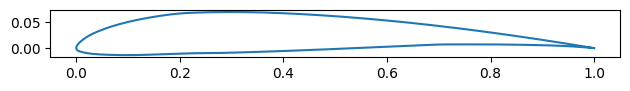

In [15]:
fig, axs = plt.subplots(1, 1)
axs.plot(data[0,:,0], data[0,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()


In [16]:
sample = np.load('sample.npy')
sample = np.squeeze(sample, axis=1)

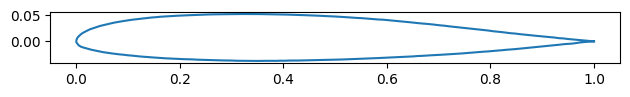

In [17]:
i = 60
fig, axs = plt.subplots(1, 1)
axs.plot(sample[i,:,0], sample[i,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

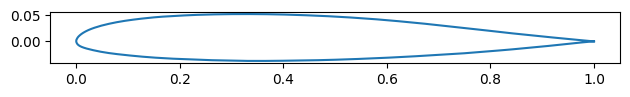

In [18]:
xhat, yhat = savgol_filter((sample[i,:,0], sample[i,:,1]), 10, 3)
fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()